# Hands on DePlot
The DePlot authors describe their model as a 'One-shot plot-to-table translation' conversion module. This notebook explores DePlot's image to structured text performance.

-Colin

## Original Work  
Source Paper: https://arxiv.org/abs/2212.10505  
Citation:
```
@misc{liu2022deplot,
      title={DePlot: One-shot visual language reasoning by plot-to-table translation},
      author={Liu, Fangyu and Eisenschlos, Julian Martin and Piccinno, Francesco and Krichene, Syrine and Pang, Chenxi and Lee, Kenton and Joshi, Mandar and Chen, Wenhu and Collier, Nigel and Altun, Yasemin},
      year={2022},
      eprint={2212.10505},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}
```

### Limitations  
* It is unknown how well DePlot can work for out-of-domain plot-to-text conversion. The authors suggest 'a wider range of web charts can be used to gain a deeper understanding into DePlot's robustness...'
* DePlot does not work for graphics and images that do not have clear textual representations. For example, a diagram of a car part does not immediately have a tabular representation.
* Orientation and color of visual objects are ignored.

### Ethics  
The authors suggest any deployment have a filtering stage after generation. Data for training was generated or available via permissive licenses.  

## Hugging Face Transformers Model  
This notebook uses the DePlot model as added to the Hugging Face ecosystem by [Younes Belkada](https://huggingface.co/ybelkada). It is available with examples at: 
https://github.com/huggingface/transformers  

## Results  
All execution times were measured using a Google Cloud Platform n1-standard-4 (4 vCPUs, 15 GB RAM) Vertex AI Notebook.

In [1]:
import re
import time
import multiprocessing
import pytesseract

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import Word
from multiprocessing.pool import ThreadPool
from io import StringIO
from PIL import Image, ImageEnhance
from IPython.display import display
from google.cloud import aiplatform
from vertexai.preview.language_models import TextGenerationModel
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration

Shared variables created in setup.ipynb

In [2]:
%store -r project_id
%store -r location_id

Initialize AI Platform and Hugging Face model

In [3]:
aiplatform.init(project=project_id, 
                location=location_id)

In [4]:
processor = Pix2StructProcessor.from_pretrained('google/deplot')
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot')

## I. Plot with Value Labels  
For a first example, let's try a plot with values labeling each plot element.  

The image:  
![](./data/5090.png)  

First prediction:

In [5]:
input_image = Image.open("./data/5090.png")

In [6]:
deplot_prompt = "Generate underlying data table of the figure below"

inputs = processor(images=input_image, 
                   text=deplot_prompt, 
                   return_tensors="pt")
predictions = model.generate(**inputs, max_new_tokens=512)

The model will output an undecoded tensor of results representing the structured text format. We'll need to clean it to work with it further.

In [7]:
predictions

tensor([[    0, 43445,   789, 32349,  2649,   789,  1879,   284,   287,  2649,
           273,    27,   595,  3709, 32616,   789,   273,   285,   292,   274,
           278,   789,   273,   290,   290,   274,   278,   273,    27,  1389,
           789, 12701,   789,   273,   285,   290,   274,   278,   273,    27,
          2165,   789,   273,   289,   290,   274,   278,   789,   273,   289,
           292,   274,   278,   273,    27,  7217,   789,   273,   285,   295,
           274,   278,   789,   273,   290,   285,   274,   278,   273,    27,
         10883,   789,   273,   289,   279,   274,   278,   789,   273,   290,
           289,   274,   278,   273,    27,  1724,   789,   273,   285,   294,
           274,   278,   789,   273,   290,   290,   274,   278,   273,    27,
           854, 42872,  2340,   273,  9345,   287,   789,   273,   289,   278,
           274,   278,   789,   273,   290,   294,   274,   278,   273,    27,
          3682,   789,   273,   279,   292,   274,  

In [8]:
output = processor.decode(predictions[0], skip_special_tokens=True)

In [9]:
output

"Entity | Individuals responsibility | Government's responsibility <0x0A> MEDIAN | 39.0 | 55.0 <0x0A> Germany | nan | 35.0 <0x0A> UK | 45.0 | 49.0 <0x0A> Sweden | 37.0 | 53.0 <0x0A> Denmark | 42.0 | 54.0 <0x0A> France | 38.0 | 55.0 <0x0A> Netherla nns | 40.0 | 58.0 <0x0A> Spain | 29.0 | 63.0 <0x0A> Italy | 22.0 | 74.0"

In [10]:
proto_table = output.replace('<0x0A>', '\n')
proto_table = re.sub(r'<.*?>', '', proto_table)
print(proto_table)

Entity | Individuals responsibility | Government's responsibility 
 MEDIAN | 39.0 | 55.0 
 Germany | nan | 35.0 
 UK | 45.0 | 49.0 
 Sweden | 37.0 | 53.0 
 Denmark | 42.0 | 54.0 
 France | 38.0 | 55.0 
 Netherla nns | 40.0 | 58.0 
 Spain | 29.0 | 63.0 
 Italy | 22.0 | 74.0


Now let's convert the `|` delimited table structure into a Pandas DataFrame. We'll clean it a bit more too.

In [11]:
df = pd.read_table(StringIO(proto_table), sep="|", header=0, skipinitialspace=True)

The column titles have trailing whitespace, which can cause issues with fancy indexing in Pandas.

In [12]:
df.columns = df.columns.str.strip()

The first column of values is technically mixed types (String and Float) due to the 'nan' value. In this case we can cast the type to `float` and Pandas will infer that 'nan' should be a null value.

In [13]:
for c in df.columns[1:]:
    df[c] = df[c].astype(float)
df.dtypes

Entity                          object
Individuals responsibility     float64
Government's responsibility    float64
dtype: object

In [14]:
df

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,NaN,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


By visual inspection, we can see a couple of obvious errors in the model generated data:  
1. The column `Individuals responsibility` should have an appostrophy (`'`) and read as `Individual's responsibility`. As this is a column title and key to user understanding of the data, it's a problematic error.
2. The value for the `Germany` row, `Individuals responsibility` column is `NaN` when in fact it should be 57. This kind of plot, called a mirrored bar chart, is labeled with text values that are not vertically aligned. The number 57 is the most out of alignment, which might have caused the model to ignore it.
3. The row title `Netherla nns` should be `Netherlands`. Inspecting the source image, there is a slight gap between the `a` and `n` in the word. This variablity might have again thrown the model off.  

### Output Plot  
Let's plot the output in a different format, just to complete a loopback from visual meaning to structured text and back to visual meaning.

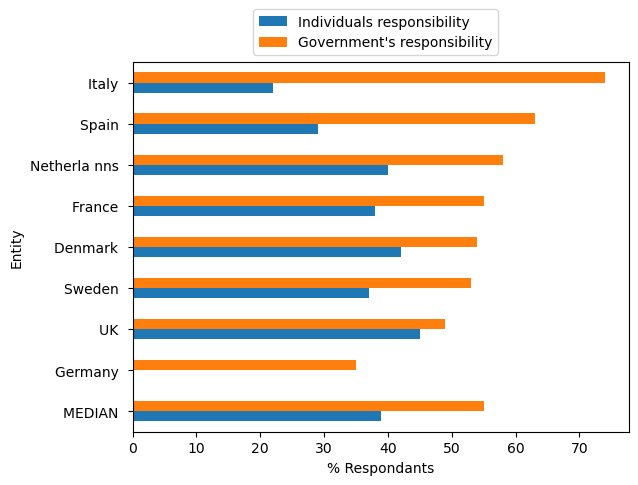

In [15]:
df_plot = df.copy()
df_plot.index = df_plot['Entity']
df_plot.plot.barh(xlabel='% Respondants').\
                  legend(loc='lower right', bbox_to_anchor=(0.75, 1));

## II. Improve Plot Performance  
Due to the errors in the initial prediction, let's alter the image before prediction and see if the results are any better. Since we're repeating work, let's define some reusable methods.  

In [16]:
def plot_d_structured(pil_image):
    """Create structured data from an input image.

    Parameters
    ----------
    pil_image : PIL.PngImagePlugin.PngImageFile, loaded image
        for structured text extraction

    Returns
    -------
    proto_table : str, structured DePlot output with some cleaning
    """
    t0 = pd.Timestamp('now')
    deplot_prompt = "Generate underlying data table of the figure below"
    inputs = processor(images=pil_image, 
                       text=deplot_prompt, 
                       return_tensors="pt")
    predictions = model.generate(**inputs, max_new_tokens=512)
    output = processor.decode(predictions[0], skip_special_tokens=True)
    proto_table = output.replace('<0x0A>', '\n')
    proto_table = re.sub(r'<.*?>', '', proto_table)
    t1 = pd.Timestamp('now')
    dt = t1-t0
    return dt, proto_table

In [17]:
def plot_2_df(pil_image):
    """Create a Pandas DataFrame from an input image.

    Parameters
    ----------
    pil_image : PIL.PngImagePlugin.PngImageFile, loaded image
        for structured text extraction

    Returns
    -------
    dt : pandas._libs.tslibs.timedeltas.Timedelta, time elapsed
    _df : Pandas DataFrame, extracted data from plot
    """
    t0 = pd.Timestamp('now')
    deplot_prompt = "Generate underlying data table of the figure below"
    inputs = processor(images=pil_image, 
                       text=deplot_prompt, 
                       return_tensors="pt")
    predictions = model.generate(**inputs, max_new_tokens=512)
    output = processor.decode(predictions[0], skip_special_tokens=True)
    proto_table = output.replace('<0x0A>', '\n')
    proto_table = re.sub(r'<.*?>', '', proto_table)
    #_df = pd.read_table(StringIO(proto_table), 
    #                    sep="|", 
    #                    header=0, 
    #                    skipinitialspace=True)
    _df = pd.read_table(StringIO(proto_table), sep="|")
    _df.columns = _df.columns.str.strip()
    t1 = pd.Timestamp('now')
    dt = t1-t0
    return dt, _df

First, let's rerun the original image:

In [18]:
dt, df2 = plot_2_df(input_image)
dt, input_image.size

(Timedelta('0 days 00:01:48.051420'), (311, 478))

In [19]:
df2

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,nan,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


In [20]:
input_image_bigger = input_image.resize(np.array(input_image.size)*3)
input_image_bigger_sharp = ImageEnhance.Sharpness(input_image_bigger).enhance(1.2)

In [21]:
dt, df3 = plot_2_df(input_image_bigger)
dt, input_image_bigger.size

(Timedelta('0 days 00:01:45.340896'), (933, 1434))

In [22]:
df3

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,nan,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


In [23]:
dt, df4 = plot_2_df(input_image_bigger_sharp)
dt, input_image_bigger_sharp.size

(Timedelta('0 days 00:01:45.994349'), (933, 1434))

In [24]:
df4

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,nan,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


So far, no change in performance or accuracy from a larger or ideally sharper edged text. Let's try some other things, starting with a greyscale image since the authors say the model does not use color as input features.

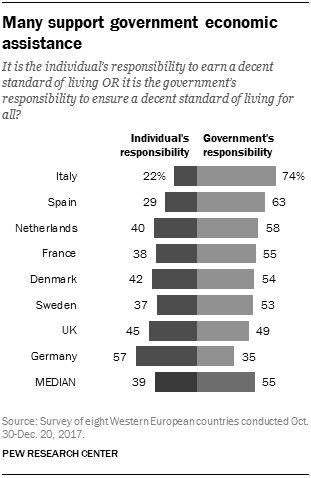

In [25]:
input_image.convert('L')

In [26]:
dt, df5 = plot_2_df(input_image.convert('L'))
dt

Timedelta('0 days 00:01:49.847010')

In [27]:
df5

,Entity,Individual's responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,nan,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


No change in performance or speed of prediction when the input is greyscale. 

Let's see how changing the horizontal and vertical scaling affects the model output.

In [28]:
input_image.size

(311, 478)

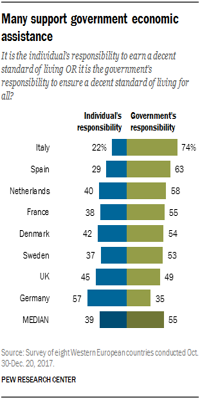

In [29]:
input_image.resize((200, 400))

In [30]:
dt, df6 = plot_2_df(input_image.resize((200, 400)))
dt

Timedelta('0 days 00:01:36.700854')

In [31]:
df6

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,57.0,35.0
2,UK,45.0,49.0
3,Sweden,nan,53.0
4,Denmark,nan,54.0
5,France,38.0,55.0
6,Netherlands,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


Interestingly with the plot narrower, we get correctly spelled `Netherlands` and the Germany's 57, but now miss the Sweden and Denmark values in the first column.  

Let's change the resize ratio in the other direction.

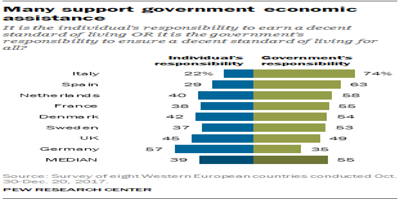

In [32]:
input_image.resize((400, 200))

In [33]:
dt, df7 = plot_2_df(input_image.resize((400, 200)))
dt

Timedelta('0 days 00:01:53.973501')

In [34]:
df7

,Year,Values
0,2008,55
1,2010,6
2,2011,7
3,2012,8
4,2013,9
5,2014,10
6,2015,7
7,2016,5
8,2017,40
9,2018,54


This is an unexpected result. The model seems to like numbers or features more vertically aligned than spread out - which perhaps makes sense since the goal is to output columnar data. Since this model result took so long to return, let's add a timeout. 

In [35]:
def function_timeout(func, args, timeout):
    """Executes another function using multiprocessing but 
    exits if more time than specified has elapsed.

    Parameters
    ----------
    func : function, the function to execute
    args : list, the arguments to pass to the function
    timeout : int, the maximum time in seconds to allow the 
        function to execute

    Returns
    -------
    The return value of the input function
    """

    with ThreadPool(processes=1) as pool:
        future = pool.apply_async(func, args)
        try:
            return future.get(timeout)
        except multiprocessing.TimeoutError:
            return None

In [36]:
def plot_2_df_timeout(pil_image, timeout=180):
    """Create a Pandas DataFrame from an input image.

    Parameters
    ----------
    pil_image : PIL.PngImagePlugin.PngImageFile, loaded image
        for structured text extraction
    timeout : int, the maximum time in seconds to allow the 
        function to execute. Default is 180 (3 minutes).
    
    Returns
    -------
    dt : pandas._libs.tslibs.timedeltas.Timedelta, time elapsed
    _df : Pandas DataFrame, extracted data from plot
    """
    result = function_timeout(plot_2_df, [pil_image], timeout)
    if result is None:
        return pd.Timedelta(f"{timeout} s"), None
    else:
        return result

In [37]:
dt, df2x = plot_2_df_timeout(input_image)
dt, input_image.size

(Timedelta('0 days 00:01:45.118023'), (311, 478))

In [38]:
df2x

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,nan,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


In [39]:
df2.equals(df2x)

True

Here we've confirmed we get the same result using the threaded timeout version as we got originally. Now we can experiment and not waste to much time.

Looking back at our results, the structured output from the narrower input image (`df6`) correctly captured some of the missing data in our original attempt (`df2`). Let's try combining them as a kind of 'average correct'.

In [40]:
def type_selector(a, b):
    """Select if both values can be represented at numeric"""
    try:
        float(a)
        float(b)
        return 'numeric'
    except:
        return 'string'

In [41]:
def not_na_selector(a, b):
    """Select the not-missing value"""
    a = float(a)
    b = float(b)
    if pd.isnull(a) & pd.notnull(b):
        return b
    elif pd.notnull(a) & pd.isnull(b):
        return a
    elif pd.isnull(a) & pd.isnull(b):
        return pd.NA

In [42]:
def word_selector(a, b):
    i = []
    w = Word(a)
    i.append(w.spellcheck()[0])
    w = Word(b)
    i.append(w.spellcheck()[0])
    _d = dict(i)
    return max(_d, key=_d.get)

In [43]:
_dfa = df2.copy()
_dfb = df6.copy()
df2_average = df2.copy()

df_mask = _dfa == _dfb
for ix in range(0, df_mask.shape[0]):
    for iy in range(0, df_mask.shape[1]):
        if df_mask.iloc[ix, iy] == False:
            a = _dfa.iloc[ix, iy]
            b = _dfb.iloc[ix, iy]
            target_type = type_selector(a, b)
            print(f"Target Type: {target_type}")
            if target_type == 'numeric':            
                c = not_na_selector(a, b)
                print(f"numeric inputs: a: {a}, b: {b}")
                df2_average.iloc[ix, iy] = c
            elif target_type == 'string':
                print(f"string Words: {a}, {b}")
                df2_average.iloc[ix, iy] = word_selector(a, b)

Target Type: numeric
numeric inputs: a:  nan , b:  57.0 
Target Type: numeric
numeric inputs: a:  37.0 , b:  nan 
Target Type: numeric
numeric inputs: a:  42.0 , b:  nan 
Target Type: string
string Words:  Netherla nns ,  Netherlands 


In [44]:
df2_average

,Entity,Individuals responsibility,Government's responsibility
0,MEDIAN,39.0,55.0
1,Germany,57.0,35.0
2,UK,45.0,49.0
3,Sweden,37.0,53.0
4,Denmark,42.0,54.0
5,France,38.0,55.0
6,Netherla nns,40.0,58.0
7,Spain,29.0,63.0
8,Italy,22.0,74.0


Reviewing these results with the original input image, we have all the values correctly captured.  

In summary, we used DePlot twice, once with the original image and once with the image compressed along the horizontal axis, then we replaced missing values where the two results overlapped and chose the strings that were spelled correctly.

## III. Check Output from Article  
In their article, the authors provide three plot images. Let's see how accurate the model is at converting them.  

Extracted image example image #1 (saved as `deplot_example_01.png`), from page 2:
![](./data/deplot_example_01.png)  

In [45]:
example_01_image = Image.open("./data/deplot_example_01.png")
dt, df_ex1 = plot_2_df_timeout(example_01_image)
dt, example_01_image.size

(Timedelta('0 days 00:00:45.009266'), (723, 507))

In [46]:
df_ex1

,TITLE,
models,augmented-set,human-set
VisionTapas,66,22
Pix2Struct,82,30
MatCha,88,37
DePlot,91,67


In [47]:
example_1_str = """
models |augmented-set|human-set
VisionTapas |67.2 |22.2
Pix2Struct |82.9 |30.4
MatCha |89.0 |38.0
DePlot |91.0 |67.6"""
df_ex1_true = pd.read_table(StringIO(example_1_str), sep="|")

In [48]:
df_ex1_true

,models,augmented-set,human-set
0,VisionTapas,67.2,22.2
1,Pix2Struct,82.9,30.4
2,MatCha,89.0,38.0
3,DePlot,91.0,67.6


Close enough, although the header row is a bit off. Remember though, the author's goal was input to an LLM so this is likely fine for that use case. Note though that the floating point accuracy of the plot has been lost, which will be reflected in any LLM application as well.  

Source for the second example:  
![](./data/deplot_example_02.png)  

In [49]:
example_02_image = Image.open("./data/deplot_example_02.png")
dt, df_ex2 = plot_2_df_timeout(example_02_image)
dt, example_02_image.size

(Timedelta('0 days 00:00:37.859238'), (1033, 778))

In [50]:
df_ex2

,Country,"Share of marine territorial waters that are protected, 2016"
0,Greenland,4.52
1,Mauritania,4.15
2,Indonesia,2.88
3,Ireland,2.33


In [51]:
example_2_str = """
country | protected-waters-percent
Greenland | 4.52
Mauritania | 4.15
Indonesia | 2.88
Ireland | 2.33"""
df_ex2_true = pd.read_table(StringIO(example_2_str), sep="|")

In [52]:
df_ex2_true

,country,protected-waters-percent
0,Greenland,4.52
1,Mauritania,4.15
2,Indonesia,2.88
3,Ireland,2.33


This example is completely correct. The only difference are the column labels.  

The third example:  
![](./data/deplot_example_03.png)  

In [53]:
example_03_image = Image.open("./data/deplot_example_03.png")
dt, df_ex3 = plot_2_df_timeout(example_03_image)
dt, example_03_image.size

(Timedelta('0 days 00:01:26.759193'), (785, 811))

In [54]:
example_3_str = """
Entity|Very concerned|Somewhat concerned|Not concerned
Children being exposed to harmful content| 79 | 14 | 6
Identity theft| 66 | 17 | 16
Exposure to false or incorrect information| 64 | 25 | 14
Mobile phone addiction| 62 | 17 | 18
Harassment or bullying| 59 | 21 | 16
Losing the ability to communicate face-to-face| 48 | 26 | 22"""
df_ex3_true = pd.read_table(StringIO(example_3_str), sep="|")

In [55]:
df_ex3_true['Entity'] = df_ex3_true['Entity'].str.strip()
df_ex3_true.sort_values(by='Entity', inplace=True)
df_ex3_true.reset_index(inplace=True, drop=True)

In [56]:
df_ex3['Entity'] = df_ex3['Entity'].str.strip()
df_ex3.sort_values(by='Entity', inplace=True)
df_ex3.reset_index(inplace=True, drop=True)

In [57]:
df_ex3_true.equals(df_ex3)

True

In [58]:
df_ex3

,Entity,Very concerned,Somewhat concerned,Not concerned
0,Children being exposed to harmful content,79,14,6
1,Exposure to false or incorrect information,64,25,14
2,Harassment or bullying,59,21,16
3,Identity theft,66,17,16
4,Losing the ability to communicate face-to-face,48,26,22
5,Mobile phone addiction,62,17,18


This result is correct too. One thing that the model seems to do though is return String values with whitespace padding on both sides. This might be an artifact of the structured data format parsing to Pandas. A string strip is sufficient to clean them up.  

## IV. Other Plot Inputs  
Data Visualization can take a lot of forms. 

Let's try a plot that likely will not translate to structured data. Charles Minard's map of Napolean's Russian campaign of 1812 was described by Edward Tufte as what "may well be the best statistical graphic ever drawn". An overview of Minard's work is on Wikipedia:  

https://en.wikipedia.org/wiki/Charles_Joseph_Minard

Edward Tufte has written extensively and is well worth reading:  
https://www.edwardtufte.com/tufte/  

![](./data/Charles_Minard_1869_Napolean_1812.png)  

In [59]:
minard_image_01 = Image.open("./data/Charles_Minard_1869_Napolean_1812.png")
dt, df_minard_01 = plot_2_df_timeout(minard_image_01)
dt, minard_image_01.size

(Timedelta('0 days 00:03:00'), (2003, 955))

That didn't end in 3 minutes, let's give the model 20 minutes. That should be more than enough time to produce something. Also since we're experimenting let's just look at the structured string output. We'll break the first function into two for more flexibility.

In [60]:
def plot_2_structured(pil_image):
    """Create structured data from an input image.

    Parameters
    ----------
    pil_image : PIL.PngImagePlugin.PngImageFile, loaded image
        for structured text extraction

    Returns
    -------
    proto_table : str, structured DePlot output with some cleaning
    """
    t0 = pd.Timestamp('now')
    deplot_prompt = "Generate underlying data table of the figure below"
    inputs = processor(images=pil_image, 
                       text=deplot_prompt, 
                       return_tensors="pt")
    predictions = model.generate(**inputs, max_new_tokens=512)
    output = processor.decode(predictions[0], skip_special_tokens=True)
    proto_table = output.replace('<0x0A>', '\n')
    proto_table = re.sub(r'<.*?>', '', proto_table)
    t1 = pd.Timestamp('now')
    dt = t1-t0
    return dt, proto_table

In [61]:
def structured_2_df(_proto_table):
    """Create a Pandas DataFrame from a DePlot structured 
    data output.

    Parameters
    ----------
    _proto_table : str, structured data output from DePlot

    Returns
    -------
    Pandas DataFrame, extracted data from plot
    """
    _df = pd.read_table(StringIO(_proto_table), sep="|")
    _df.columns = _df.columns.str.strip()
    return _df

In [62]:
def plot_2_df(pil_image):
    """Create a Pandas DataFrame from an input image.

    Parameters
    ----------
    pil_image : PIL.PngImagePlugin.PngImageFile, loaded image
        for structured text extraction

    Returns
    -------
    dt : pandas._libs.tslibs.timedeltas.Timedelta, time elapsed
    _df : Pandas DataFrame, extracted data from plot
    """
    t0 = pd.Timestamp('now')
    _, proto_table = plot_2_structured(pil_image)
    _df = structured_2_df(proto_table)
    t1 = pd.Timestamp('now')
    dt = t1-t0
    return dt, _df

In [63]:
def plot_2_structured_timeout(pil_image, timeout=180):
    """Create a Pandas DataFrame from an input image.

    Parameters
    ----------
    pil_image : PIL.PngImagePlugin.PngImageFile, loaded image
        for structured text extraction
    timeout : int, the maximum time in seconds to allow the 
        function to execute. Default is 180 (3 minutes).
    
    Returns
    -------
    dt : pandas._libs.tslibs.timedeltas.Timedelta, time elapsed
    _df : Pandas DataFrame, extracted data from plot
    """
    result = function_timeout(plot_2_structured, [pil_image], timeout)
    if result is None:
        return pd.Timedelta(f"{timeout} s"), None
    else:
        return result

In [64]:
# takes roughly 11 minutes
minard_image_01 = Image.open("./data/Charles_Minard_1869_Napolean_1812.png")
dt, txt_minard_01 = plot_2_structured_timeout(minard_image_01, timeout=1200)
dt, minard_image_01.size

(Timedelta('0 days 00:17:52.237264'), (2003, 955))

In [65]:
print(txt_minard_01)

TITLE |  
  | Kw
Rk. | M
G | GA
Yds 
 1. | 16.5 | 12.2 | 5.5 
 2. | 15.2 | 11.0 | 3.5 
 3. | 14.5 | 10.5 | 6.5 
 4. | 12.6 | 11.4 | 6.5 
 5. | 12.2 | 11.6 | 6.5 
 6. | 12.2 | 11.0 | 7.5 
 7. | 12.2 | 11.0 | 7.8 
 8. | 12.2 | 10.8 | 8.3 
 9. | 12.2 | 10.4 | 8.0 
 10. | 12.2 | 10.0 | 8.5 
 11. | 12.2 | 9.4 | 8.0 
 12. | 12.2 | 9.0 | 8.5 
 13. | 12.2 | 8.8 | 8.0 
 14. | 12.2 | 8.0 | 7.6 
 15. | 12.2 | 8.5 | 7.8 
 16. | 12.2 | 8.0 | 7.5 
 17. | 12.2 | 8.0 | 7.5 
 18. | 12.2 | 8.5 | 8.0 
 19. | 12.2 | 8.0 | 7.5 
 18. | 12.2 | 8.0 | 7.5 
 17. | 12.2 | 8.0 | 7.5 
 18. | 12.2 | 8.0 | 7.5 
 1


The output is not at all what the original plot was representing, but we expected this. The ideal output might describe the army strength (size in people) as it relates to the distance traveled:  
```
distance | size
0 | 422,000
50 | 400,000
100 | 375,000
150 | 350,000
200 | 325,000
```

Let's try a well made modern graphic from the New York Times. This was captured from the article `‘Barbenheimer’ Weekend Was a Real Team Effort`, By Jason Karaian and Karl Russell and published July 24, 2023. Accessed online at: https://www.nytimes.com/2023/07/24/business/barbie-oppenheimer-weekend-box-office.html  

![](./data/nytime_2023_07_24_box_office.png)  

In [66]:
karaian_russel_image_01 = Image.open("./data/nytime_2023_07_24_box_office.png")
dt, txt_karaian_russel_01 = plot_2_structured_timeout(karaian_russel_image_01)
dt, karaian_russel_image_01.size

(Timedelta('0 days 00:02:32.317687'), (774, 645))

In [67]:
print(txt_karaian_russel_01)

TITLE | Each top movie's share of weekend box Office Grosses
Year | Biggest Domestic Weekend Box Office Grosses
2010 | Biggest Domestic Weekend Box Office Grosses
2011 | Biggest Domestic Weekend Box Office Grosses
2012 
 July 24, 2023 | 2 | 1 
 By Jason Karaian and Karl Russell | 0 | 1 
 Source: Box Office Mojo | 0 | 1 
 April 26–28
2019 | 37 | 83 
 April 27–29
2018 | 253 | 32 
 Dec. 18–20
2015 | 313 | 31 
 July 21–23
2023 | 232 | 22


This took about 2.5 minutes and came out looking well formatted but somewhat nonsensical. Extracting the most salient part and doing some manual reformatting:  
```
 April 26–28 2019 | 37 | 83 
 April 27–29 2018 | 253 | 32 
 Dec. 18–20 2015 | 313 | 31 
 July 21–23 2023 | 232 | 22
```
We can see the date ranges are accurately captured but the dollar values and percentages are not accurate. Let's give the model less to work with and crop the image.

All surrounding data cropped:  
![](./data/nytime_2023_07_24_box_office_cropped.jpg)  

In [68]:
karaian_russel_image_02 = Image.open("./data/nytime_2023_07_24_box_office_cropped.jpg")
dt, txt_karaian_russel_02 = plot_2_structured_timeout(karaian_russel_image_02)
dt, karaian_russel_image_02.size

(Timedelta('0 days 00:01:02.548510'), (750, 368))

In [69]:
print(txt_karaian_russel_02)

TITLE |  
  | Charities 
 April 26–28
2019 | 402
million 
 April 27–29
2018 | 325.5 
 December 18–20
2015 | 324.5 
 July 21–23
2023 | 352.7


This is an interesting observation since OCR has been very accurate for a long time. Let's see what Tesseract, an open source OCR application, can do with the cropped image.

In [70]:
fp_karaian_russel_cropped = 'data/nytime_2023_07_24_box_office_cropped.jpg'
img_karaian_russel_03 = np.array(Image.open(fp_karaian_russel_cropped))
txt_karaian_russel_03 = pytesseract.image_to_string(img_karaian_russel_03)
print(txt_karaian_russel_03)

July 21-23
2023

Dec. 18-20
2015

April 27-29
2018

April 26-28
2019

$311
million

$313
million

$314
million

$402
million



That's closer to what we're looking for. The dates and dollar values are correct. Tesseract supports much more than this simple example. It has a long development history and is currently developed by Google. Read more here:  
https://github.com/tesseract-ocr/tesseract  

## V. Generated Plot Data  
Let's make some plots with data we know is structured. That way any errors in DePlot output are an artifact of the model performance.

In [71]:
dfx = pd.DataFrame({'a':[1,2,3],
                    'b':[4,5,6]},
                   index=['this', 'that', 'other'])
dfx

,a,b
this,1,4
that,2,5
other,3,6


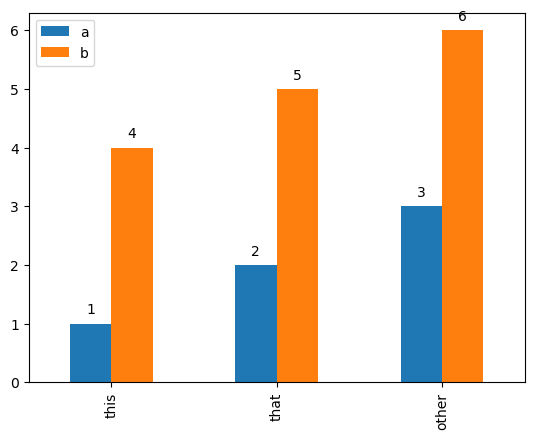

In [72]:
ax = dfx.plot.bar()
for container in ax.containers:
    ax.bar_label(container, padding=5)
fig = ax.get_figure()
fig.savefig('data/_temp.png')

In [73]:
gen_image_01 = Image.open("data/_temp.png")
dt, txt_gen_image_01 = plot_2_structured_timeout(gen_image_01)
dt, gen_image_01.size

(Timedelta('0 days 00:00:26.217748'), (640, 480))

In [74]:
print(txt_gen_image_01)

TITLE |  
  | a | b 
 this | 1 | 4 
 that | 2 | 5 
 other | 3 | 6


Pretty good, let's compare it to tesseract.

In [75]:
tesseract_array = np.array(Image.open('./data/_temp.png'))
txt_tesseract_temp = pytesseract.image_to_string(tesseract_array)
print(txt_tesseract_temp)

 

 

 

 

 

 

0

4eun0



Pretty much nothing out from tesseract OCR. Let's try some more configurations of this plot.

TITLE |  
  | a | b 
 this | 1 | 4 
 that | 2 | 5 
 other | 3 | 6


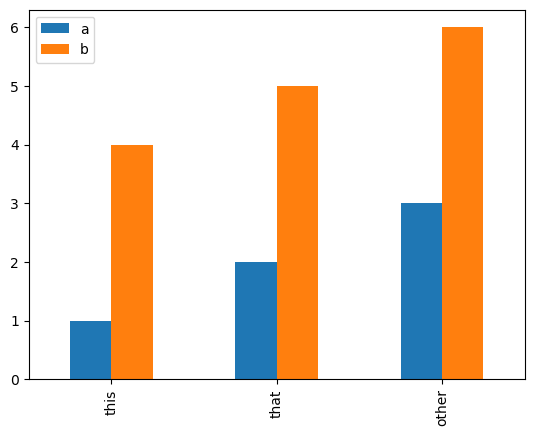

In [76]:
ax = dfx.plot.bar()
#for container in ax.containers:
#    ax.bar_label(container, padding=5)
fig = ax.get_figure()
fig.savefig('data/_temp.png')
gen_image_02 = Image.open("data/_temp.png")
dt, txt_gen_image_02 = plot_2_structured_timeout(gen_image_02)
dt, gen_image_02.size
print(txt_gen_image_02)

In [77]:
structured_2_df(txt_gen_image_02)

,TITLE,
,a,b
this,1,4
that,2,5
other,3,6


Now this is getting interesting. This time, the model was able to convert the plot to data without data labels. That is, it read the axis and inferred values spatially between the graphical entities of the plot. It continues to be inconsistent in header and table formatting which would be a challenge to generalize handling in a data pipeline. 

TITLE |  
 a | nan 
 this | nan 
 that | nan


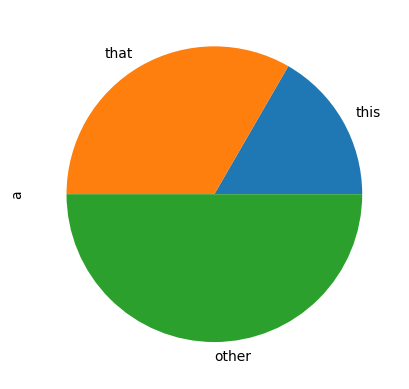

In [78]:
ax = dfx.plot.pie(y='a', legend=False)
fig = ax.get_figure()
fig.savefig('data/_temp.png')
gen_image_03 = Image.open("data/_temp.png")
dt, txt_gen_image_03 = plot_2_structured_timeout(gen_image_03)
dt, gen_image_03.size
print(txt_gen_image_03)

Pie charts don't work. Which is fine, we shouldn't be [using them anyway](https://scc.ms.unimelb.edu.au/resources/data-visualisation-and-exploration/no_pie-charts).

TITLE |  
 other |  
 a | 6 
 b | 0 
 c | 1


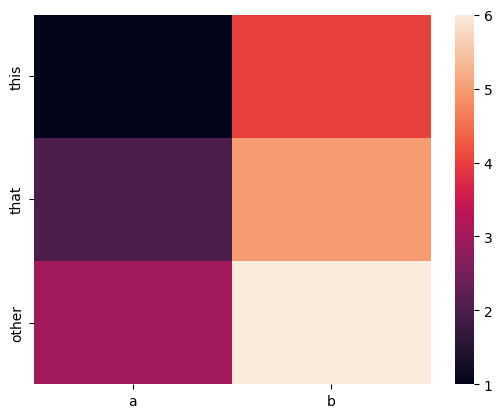

In [79]:
ax = sns.heatmap(dfx)
fig = ax.get_figure()
fig.savefig('data/_temp.png')
gen_image_04 = Image.open("data/_temp.png")
dt, txt_gen_image_04 = plot_2_structured_timeout(gen_image_04)
dt, gen_image_04.size
print(txt_gen_image_04)

So this is interesting, not that the model halicinated the value 0, it appears nowhere on the chart. The only similar character is the 'o' in other, which is already returned as a column title.

TITLE |  
  | 1 
 a | 3 
 b | 6 
 c | 2


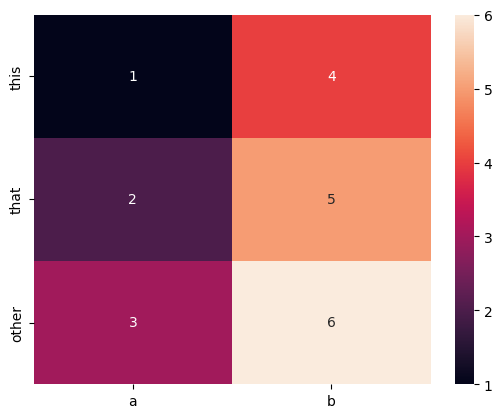

In [80]:
ax = sns.heatmap(dfx, annot=True)
fig = ax.get_figure()
fig.savefig('data/_temp.png')
gen_image_05 = Image.open("data/_temp.png")
dt, txt_gen_image_05 = plot_2_structured_timeout(gen_image_05)
dt, gen_image_05.size
print(txt_gen_image_05)

With annotations, some of the data is represented. Perhaps the model selected data along a path in the bottom row (other). Nothing concrete, this kind of data output would be hard to programatically extract from new plots.

TITLE |  
 other | 3 
 a | 3 
 b | 6


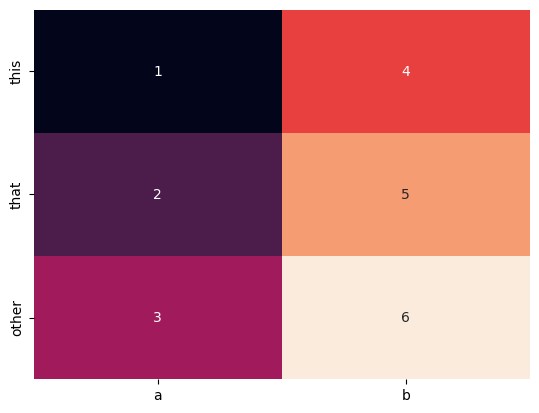

In [81]:
ax = sns.heatmap(dfx, annot=True, cbar=False)
fig = ax.get_figure()
fig.savefig('data/_temp.png')
gen_image_06 = Image.open("data/_temp.png")
dt, txt_gen_image_06 = plot_2_structured_timeout(gen_image_06)
dt, gen_image_06.size
print(txt_gen_image_06)

This is still not capturing the data, which is disappointing since this is about as rectilinearly structured a data plot as we could get.  Let's try reconfiguring the heatmap a bit, perhaps something will come out more clearly.

TITLE |  
  | 4 
 1 | 1 
 2 | 2 
 3 | 3 
 4 | 5


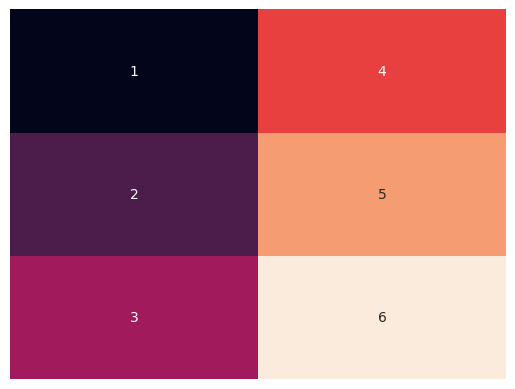

In [82]:
ax = sns.heatmap(dfx, annot=True, 
                 xticklabels=False, yticklabels=False, 
                 cbar=False)
fig = ax.get_figure()
fig.savefig('data/_temp.png')
gen_image_07 = Image.open("data/_temp.png")
dt, txt_gen_image_07 = plot_2_structured_timeout(gen_image_07)
dt, gen_image_07.size
print(txt_gen_image_07)

No luck, also where the sequence `1,2,3,5` came from is puzzling. Let's double check with OCR.

In [83]:
img2 = np.array(Image.open("data/_temp.png"))
text = pytesseract.image_to_string(img2)
text

' \n\x0c'

Even worse. Let's resize the heatmap.

In [84]:
def figure_2_txt(fig):
    fig.savefig('data/_temp.png')
    _gen_image = Image.open("data/_temp.png")
    dt, _txt_gen_image = plot_2_structured_timeout(_gen_image)
    print(f"Time elapsed: {dt}, size of image: {_gen_image.size}")
    return _txt_gen_image

Time elapsed: 0 days 00:00:27.818837, size of image: (300, 300)
TITLE |  
  | 4 
 1 | 1 
 2 | 2 
 3 | 5 
 4 | 4


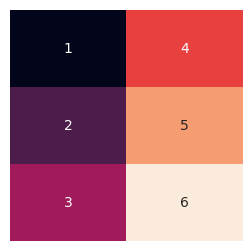

In [85]:
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(dfx, annot=True, 
            xticklabels=False, yticklabels=False, 
            cbar=False, ax=ax)
txt = figure_2_txt(ax.get_figure())
print(txt)

Time elapsed: 0 days 00:00:22.067365, size of image: (100, 100)
TITLE |  
  | 3 | 5 
 | 2 | 5 
 | 1 | 4


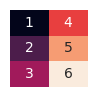

In [86]:
fig, ax = plt.subplots(figsize=(1,1))
sns.heatmap(dfx, annot=True, 
            xticklabels=False, yticklabels=False, 
            cbar=False, ax=ax)
txt = figure_2_txt(ax.get_figure())
print(txt)

This result is mostly correct. And it follows a pattern that other results have taken which is the rows are returned in reverse sorted order from their top to bottom location in the plot.

Time elapsed: 0 days 00:00:51.863724, size of image: (100, 100)
TITLE |  
  | AFC Central
T | AFC Central
W | AFC Central
L | AFC Central
PA 
 (1) | 3 | 2 | 5 | 6 
 (4) | 2 | 1 | 5 | 5 
 (5) | 0 | 0 | 1 | 4


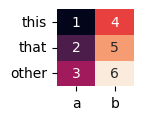

In [87]:
fig, ax = plt.subplots(figsize=(1,1))
sns.heatmap(dfx, annot=True, 
            xticklabels=True, yticklabels=True, 
            cbar=False, ax=ax)
txt = figure_2_txt(ax.get_figure())
print(txt)

This result is worse than useless; it's actively inserting uncertainty into the analysis by returning content that is not present in the input image (all of the `AFC Central` labels, plus the shape mismatch of the input and output).

## VI. Conclusions  
In limited situations, DePlot is able to generate structured data from charts and plots. As trained by the authors, the model is not sufficiently accurate to be used in a production data pipeline. 

The authors of DePlot evaluated their model performance using two published datasets: `ChartQA` and `PlotQA` at 1/3 each and the last 1/3 their own annotated data. Clearly further fine-tuning would be required on a specific domain before DePlot is ready for an application specific deployment. Indeed, the authors state:

```
To obtain effective plot-to-text conversion, large amounts of diverse and in-domain plot-table parallel data are usually needed. It is unknown to which extent DEPLOT can work for out-of-domain (OOD) plotto text conversion. We investigated this in section §6.2 but in the future a wider range of web charts can be used to gain a deeper understanding into DEPLOT’s robustness for OOD plots
```

A limitation of this Notebook study is that we have potentially evaluated the model out-of-domain. The authors state `DEPLOT is conceptually simple yet can robustly work for all types of charts (line, dot, bar, and pie charts)` - which does not include stacked bar charts, heatmaps or anything like Minard's map.

Next steps could be finding an application specific domain and training DePlot on just that application and evaluating performance. 